In [27]:
import json
import os

import pprint
import matplotlib.pyplot as plt
from   merlion.evaluate.forecast import (
    ForecastEvaluator, ForecastEvaluatorConfig, ForecastMetric)
from   merlion.models.ensemble.combine import Mean, ModelSelector
from   merlion.models.ensemble.forecast import (
    ForecasterEnsemble, ForecasterEnsembleConfig)
from   merlion.models.factory import ModelFactory
from   merlion.models.forecast.arima import Arima, ArimaConfig
from   merlion.models.forecast.prophet import Prophet, ProphetConfig
from   merlion.models.forecast.smoother import MSES, MSESConfig
from   merlion.transform.base import Identity
from   merlion.transform.resample import TemporalResample
from   merlion.utils.time_series import TimeSeries as TS
import numpy as np
from   ts_datasets.forecast import M4

In [3]:
ts, meta = M4(subset='Hourly')[5]
trainval = meta['trainval']

100%|████████████████████████████████████████| 414/414 [00:00<00:00, 1228.18it/s]


In [4]:
ts.head()

,H6
1970-01-01 00:00:00,5780.0
1970-01-01 01:00:00,5497.0
1970-01-01 02:00:00,5306.0
1970-01-01 03:00:00,5178.0
1970-01-01 04:00:00,5235.0


In [5]:
meta.head()

,trainval
1970-01-01 00:00:00,True
1970-01-01 01:00:00,True
1970-01-01 02:00:00,True
1970-01-01 03:00:00,True
1970-01-01 04:00:00,True


In [6]:
meta.trainval.value_counts()

True     700
False     48
Name: trainval, dtype: int64

In [7]:
deltas = np.diff(ts.index)
print(f'Has missing data: {any(deltas != deltas[0])}')

Has missing data: False


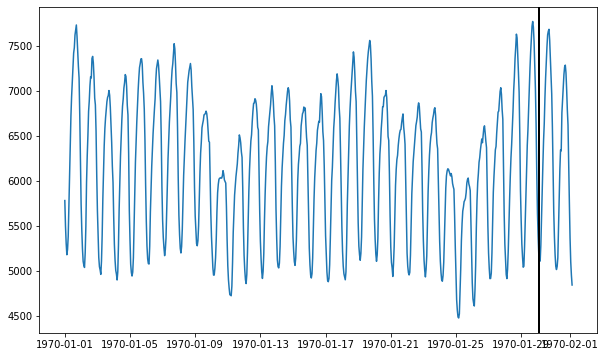

In [8]:
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111)
ax.plot(ts)
ax.axvline(ts[trainval].index[-1], c='k', lw=2);

In [9]:
train = TS.from_pd(ts[trainval])
test = TS.from_pd(ts[-trainval])

### Model Init
Models included here:
- ARIMA
- Prophet (Facebook forecasting model)
- MSES (Multi-Scale Exponential Smoothing; Salesforce model)

In [10]:
config1 = ArimaConfig(max_forecast_steps=100, 
                      order=(20, 1, 5), 
                      transform=TemporalResample(granularity='1h'))
mod1 = Arima(config1)

config2 = ProphetConfig(max_forecast_steps=100, transform=Identity())
mod2 = Prophet(config2)

config3 = MSESConfig(max_forecast_steps=100, 
                     max_backstep=60, 
                     transform=TemporalResample(granularity='1h'))
mod3 = MSES(config3)

Evaluation metric: sMAPE (symmetric Mean Average Precision Error):
sMAPE(y, yhat) = (200/T)∑(|yhat[t] - y[t]| / (|yhat[t]| + |y[t]|))
.....where t = 1, 2, ..., T

In [11]:
# The ForecasterEnsemble is a forecaster, and we treat it as a first-class 
# model.
# Its config takes a combiner object, specifying how you want to combine
# the predictions of individual models in the ensemble. There are two ways 
# to specify the actual models in the ensemble, which we cover below.

# The first way to specify the models in the ensemble is to provide their
# individual configs when initializing the ForecasterEnsembleConfig. Note
# that if using this syntax, you must also provide the names of the model
# classes.
#
# The combiner here will simply take the mean prediction of the ensembles
# here
ensemble_config = ForecasterEnsembleConfig(
    combiner=Mean(),
    model_configs=[(type(mod1).__name__, config1),
                   (type(mod2).__name__, config2),
                   (type(mod3).__name__, config3)])
ensemble = ForecasterEnsemble(config=ensemble_config)

In [12]:
# Alternatively, you can skip giving the individual model configs to the
# ForecasterEnsembleConfig, and instead directly specify the models when
# initializing the ForecasterEnsemble itself.
#
# The combiner here uses the sMAPE to compare individual models, and
# selects the model with the lowest sMAPE
selector_config = ForecasterEnsembleConfig(
    combiner=ModelSelector(metric=ForecastMetric.sMAPE))
selector = ForecasterEnsemble(
    config=selector_config, models=[mod1, mod2, mod3])

### Model Training

In [13]:
print(f'Training {type(mod1).__name__}...')
forecast1, se1 = mod1.train(train)
#print('se:', se1.mean())

print(f'\nTraining {type(mod2).__name__}...')
forecast2, se2 = mod2.train(train)
#print('se:', se2.mean())

print(f'\nTraining {type(mod3).__name__}...')
forecast3, se3 = mod3.train(train)
#print('se:', se3.mean())

print('\nTraining ensemble...')
forecastE, seE = ensemble.train(train)
#print('se:', seE.mean())

print('\nTraining model selector...')
forecastS, seS = selector.train(train)
#print('se:', seS.mean())

print('Done!')

Training Arima...


INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Training Prophet...
Initial log joint probability = -8.3005
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2193.1    0.00973352       815.286           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2210.03   0.000340525       304.979      0.3065      0.3065      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2216.11    0.00353292        324.32           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       2217.69   2.74846e-05       72.6974   3.581e-07       0.001      490  LS failed, Hessian reset 
     399        2217.9   0.000271913       85.4299           1           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     415       2218.

INFO:merlion.models.ensemble.forecast:Training model 1/3...



Training ensemble...


INFO:merlion.models.ensemble.forecast:Training model 2/3...
INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Training model 3/3...


Initial log joint probability = -8.3005
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2193.1    0.00973352       815.286           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2210.03   0.000340525       304.979      0.3065      0.3065      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2216.11    0.00353292        324.32           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       2217.69   2.74846e-05       72.6974   3.581e-07       0.001      490  LS failed, Hessian reset 
     399        2217.9   0.000271913       85.4299           1           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     415       2218.11   4.80707e-05     

INFO:merlion.models.ensemble.forecast:Training model 1/3...



Training model selector...


INFO:merlion.models.ensemble.forecast:Training model 2/3...
INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Training model 3/3...


Initial log joint probability = -6.35525
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1829.96    0.00294131       190.158           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1839.01    0.00334766       264.725       0.644           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1843.57   0.000901711       314.737      0.9229      0.9229      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1846.76    0.00152297       158.615           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1848.26   0.000348403       284.443      0.4576      0.4576      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:merlion.models.ensemble.forecast:Evaluating validation performance...
Validation: 100%|████████████████████| 500400/500400 [00:00<00:00, 519820.08it/s]
INFO:merlion.models.ensemble.forecast:Re-training model 1/3 on full data...
INFO:merlion.models.ensemble.forecast:Re-training model 2/3 on full data...
INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Re-training model 3/3 on full data...


Initial log joint probability = -8.3005
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2193.1    0.00973352       815.286           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2210.03   0.000340525       304.979      0.3065      0.3065      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2216.11    0.00353292        324.32           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       2217.69   2.74846e-05       72.6974   3.581e-07       0.001      490  LS failed, Hessian reset 
     399        2217.9   0.000271913       85.4299           1           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     415       2218.11   4.80707e-05     

### Model Inference

In [14]:
# Truncate the test data to ensure that we are within each model's maximum
# forecast horizon.
sub_test = test[:50]
time_stamps = sub_test.univariates[sub_test.names[0]].time_stamps

In [15]:
# Get the forecast & standard error of each model. These are both
# merlion.utils.TimeSeries objects. Note that the standard error is None 
# for models which don't support uncertainty estimation (like MSES and all
# ensembles).
forecast1, se1 = mod1.forecast(time_stamps=time_stamps)
forecast2, se2 = mod2.forecast(time_stamps=time_stamps)

# You may optionally specify a time series prefix as context. If one isn't
# specified, the prefix is assumed to be the training data. Here, we just 
# make this dependence explicit. More generally, this feature is useful if
# you want to use a pre-trained model to make predictions on data further
# in the future from the last time it was trained.
forecast3, se3 = mod3.forecast(time_stamps=time_stamps, 
                               time_series_prev=train)

# The same options are available for ensembles as well, though the stderr
# is None
forecastE, seE = ensemble.forecast(time_stamps=time_stamps)
forecastS, seS = selector.forecast(time_stamps=time_stamps, 
                                   time_series_prev=train)

### Mod Vis and Eval

sMAPE: 3.778


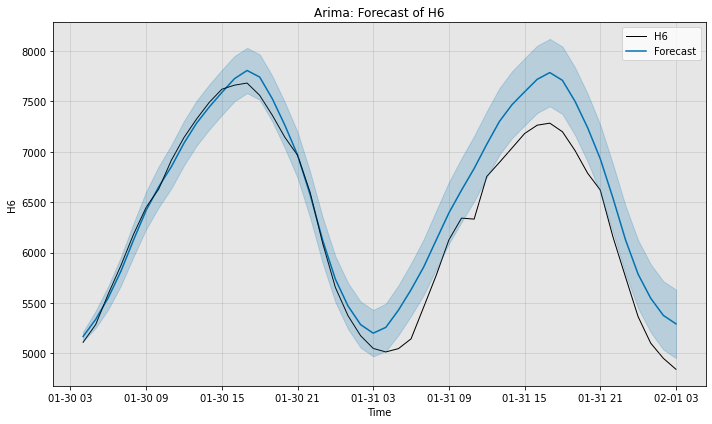

In [16]:
smape1 = ForecastMetric.sMAPE.value(ground_truth=sub_test, 
                                    predict=forecast1)
print(f'sMAPE: {smape1:.3f}')
fig, ax = mod1.plot_forecast(time_series=sub_test, 
                             plot_forecast_uncertainty=True)

sMAPE: 3.045


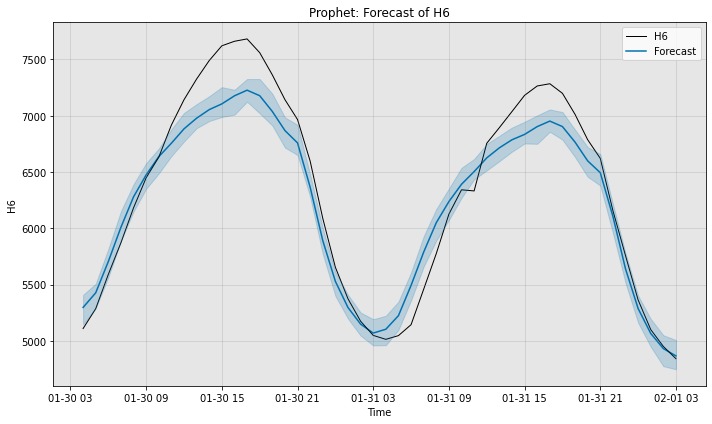

In [17]:
smape2 = ForecastMetric.sMAPE.value(ground_truth=sub_test, 
                                    predict=forecast2)
print(f'sMAPE: {smape2:.3f}')
fig, ax = mod2.plot_forecast(time_series=sub_test,
                             time_series_prev=train,
                             plot_forecast_uncertainty=True)

sMAPE: 4.377


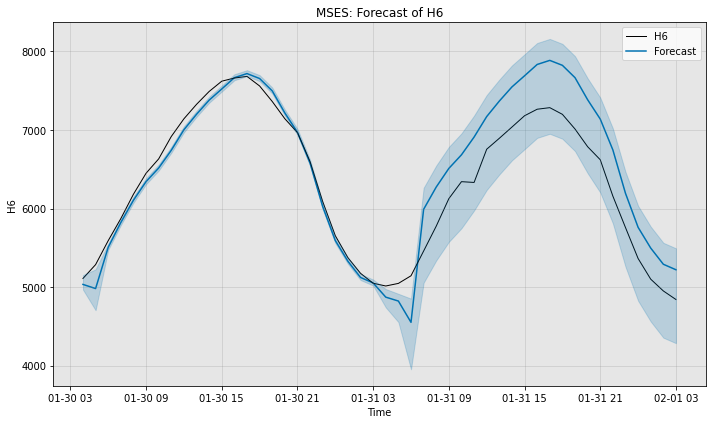

In [18]:
smape3 = ForecastMetric.sMAPE.value(ground_truth=sub_test, 
                                    predict=forecast3)
print(f'sMAPE: {smape3:.3f}')
fig, ax = mod3.plot_forecast(time_series=sub_test, 
                             plot_forecast_uncertainty=True)

sMAPE: 2.518


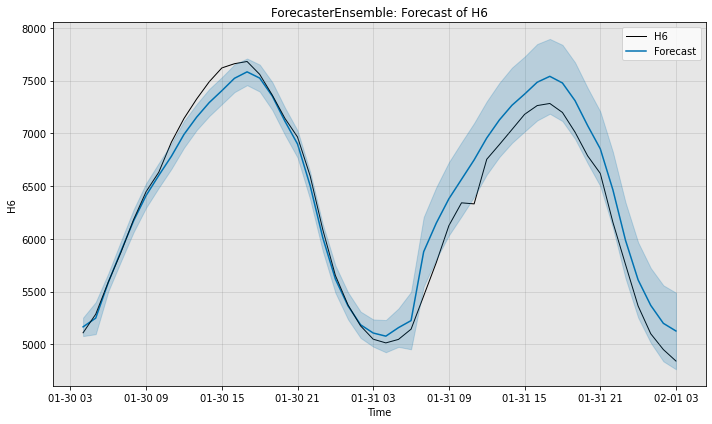

In [19]:
smapeE = ForecastMetric.sMAPE.value(ground_truth=sub_test, 
                                    predict=forecastE)
print(f'sMAPE: {smapeE:.3f}')
fig, ax = ensemble.plot_forecast(time_series=sub_test, 
                                 plot_forecast_uncertainty=True)

sMAPE: 3.778


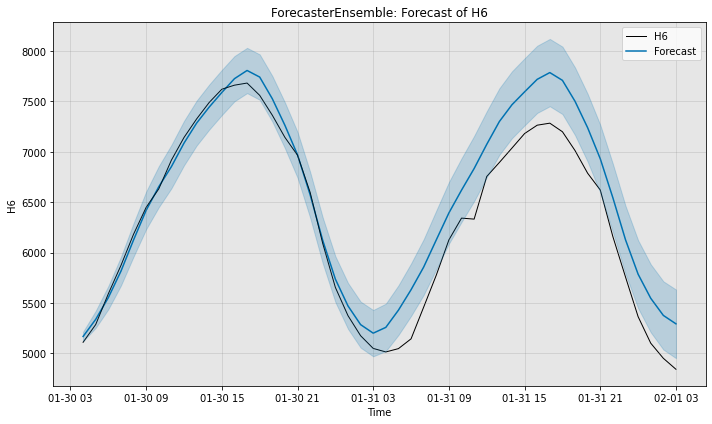

In [20]:
smapeS = ForecastMetric.sMAPE.value(ground_truth=sub_test, 
                                    predict=forecastS)
print(f'sMAPE: {smapeS:.3f}')
fig, ax = selector.plot_forecast(time_series=sub_test, 
                                 plot_forecast_uncertainty=True)

### Saving/Loading

In [21]:
os.makedirs('models', exist_ok=True)
path = os.path.join('models', 'prophet')
mod2.save(path)

In [24]:
pp = pprint.PrettyPrinter()
with open(os.path.join(path, 'config.json')) as f:
    print(f'{type(mod2).__name__} Config')
    pp.pprint(json.load(f))

Prophet Config
{'add_seasonality': 'auto',
 'daily_seasonality': 'auto',
 'dim': 1,
 'max_forecast_steps': 100,
 'model_path': '/Users/damiansp/Learning/TS/python/merlion/forecasting/models/prophet/model.pkl',
 'target_seq_index': 0,
 'transform': {'name': 'Identity'},
 'uncertainty_samples': 100,
 'weekly_seasonality': 'auto',
 'yearly_seasonality': 'auto'}


In [25]:
mod2_loaded = Prophet.load(dirname=path) # or
mod2_factory_loaded = ModelFactory.load(name='Prophet', model_path=path)

In [26]:
# Save the selector
path = os.path.join('models', 'selector')
selector.save(path)

with open(os.path.join(path, 'config.json')) as f:
    print('Selector Config')
    pp.pprint(json.load(f))
    
selector_loaded = ForecasterEnsemble.load(dirname=path) # OR
selector_factory_loaded = ModelFactory.load(name='ForecasterEnsemble',
                                            model_path=path)

Selector Config
{'combiner': {'abs_score': False,
              'metric': 'ForecastMetric.sMAPE',
              'metric_values': [5.748754624382501,
                                8.599299515557673,
                                17.72980301555831],
              'n_models': 3,
              'name': 'ModelSelector'},
 'dim': 1,
 'max_forecast_steps': None,
 'model_paths': [['Arima',
                  '/Users/damiansp/Learning/TS/python/merlion/forecasting/models/selector/0'],
                 ['Prophet',
                  '/Users/damiansp/Learning/TS/python/merlion/forecasting/models/selector/1'],
                 ['MSES',
                  '/Users/damiansp/Learning/TS/python/merlion/forecasting/models/selector/2']],
 'target_seq_index': 0,
 'transform': {'name': 'Identity'}}


### Simulate Live Deploy

In [30]:
def create_evaluator(mod):
    # reinit mod so it can be retrained from scratch
    mod.reset()
    
    # Eval pipeline:
    # - get hourly forecast w/ 6 hr horizon
    # - retrain every 12 hrs
    # - retrain on last 2 weeks only
    evaluator = ForecastEvaluator(
        model=mod,
        config=ForecastEvaluatorConfig(cadence='1h', 
                                       horizon='6h', 
                                       retrain_freq='12h', 
                                       train_window='14d'))
    return evaluator

In [32]:
# Evaluate ARIMA
mod1_eval = create_evaluator(mod1)
mod1_train_res, mod1_test_res = mod1_eval.get_predict(train_vals=train, 
                                                      test_vals=test)

ForecastEvaluator: 100%|██████████████| 169200/169200 [00:07<00:00, 22892.31it/s]


In [35]:
# sMAPE and RMSE for ARIMA
smape, rmse = [
    mod1_eval.evaluate(ground_truth=test, 
                       predict=mod1_test_res, 
                       metric=m)
    for m in [ForecastMetric.sMAPE, ForecastMetric.RMSE]]

print(f'{type(mod1).__name__} sMAPE: {smape:7.3f}')
print(f'{type(mod1).__name__}  RMSE: {rmse:.3f}')

Arima sMAPE:   2.017
Arima  RMSE: 143.548


In [36]:
ensemble_eval = create_evaluator(ensemble)
ensemble_train_res, ensemble_test_res = ensemble_eval.get_predict(
    train_vals=train, test_vals=test)

INFO:merlion.models.ensemble.forecast:Training model 1/3...
INFO:merlion.models.ensemble.forecast:Training model 2/3...
INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Training model 3/3...


Initial log joint probability = -8.3005
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2193.1    0.00973352       815.286           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2210.03   0.000340525       304.979      0.3065      0.3065      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2216.11    0.00353292        324.32           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       2217.69   2.74846e-05       72.6974   3.581e-07       0.001      490  LS failed, Hessian reset 
     399        2217.9   0.000271913       85.4299           1           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     415       2218.11   4.80707e-05     

ForecastEvaluator:  26%|███▊           | 43200/169200 [00:02<00:07, 16661.16it/s]INFO:merlion.models.ensemble.forecast:Training model 1/3...
INFO:merlion.models.ensemble.forecast:Training model 2/3...
INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Training model 3/3...


Initial log joint probability = -7.47985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1037.39   0.000470845       116.423           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       1039.61   0.000103091       116.059   1.153e-06       0.001      219  LS failed, Hessian reset 
     172       1041.42   6.98735e-05       68.0487    5.21e-07       0.001      294  LS failed, Hessian reset 
     199       1042.11    0.00173183       323.627           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       1042.76   0.000195075       180.075   9.036e-07       0.001      375  LS failed, Hessian reset 
     254       1044.26   0.000329979       109.787   1.505e-06       0.001      460  LS failed, Hessian reset 
     299       1044.88   0.000278975       144.441      0.8186   

ForecastEvaluator:  51%|███████▋       | 86400/169200 [00:08<00:05, 15838.32it/s]INFO:merlion.models.ensemble.forecast:Training model 1/3...
INFO:merlion.models.ensemble.forecast:Training model 2/3...
INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Training model 3/3...


Initial log joint probability = -7.46925
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1030.49     0.0095992        310.02           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       1035.88   0.000105236       120.259   9.744e-07       0.001      233  LS failed, Hessian reset 
     199       1038.05    0.00155351       114.533      0.8953      0.8953      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       1039.18    0.00017295       185.572   1.052e-06       0.001      429  LS failed, Hessian reset 
     299       1039.95   0.000433032       81.3296           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1041.36   0.000416387       100.168           1           1      611   
    Iter      log pro

ForecastEvaluator:  77%|██████████▋   | 129600/169200 [00:13<00:02, 15440.17it/s]INFO:merlion.models.ensemble.forecast:Training model 1/3...
INFO:merlion.models.ensemble.forecast:Training model 2/3...
INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Training model 3/3...


Initial log joint probability = -6.81543
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1008.03    0.00168901       217.135      0.6397      0.6397      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1013.36     0.0140137       828.313           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       1014.01   0.000173699       154.702   1.085e-06       0.001      276  LS failed, Hessian reset 
     280       1016.81   0.000218862       183.493    1.26e-06       0.001      409  LS failed, Hessian reset 
     299       1017.42   8.68331e-05       75.8968      0.2592      0.2592      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345        1018.1   0.000187885       121.122   2.868e-06       0.001      528  LS failed, Hessian rese

ForecastEvaluator: 100%|███████████████| 169200/169200 [00:19<00:00, 8638.65it/s]


In [37]:
smape, rmse = [
    ensemble_eval.evaluate(ground_truth=test, 
                           predict=mod1_test_res, 
                           metric=m)
    for m in [ForecastMetric.sMAPE, ForecastMetric.RMSE]]

print(f'Ensemble sMAPE: {smape:7.3f}')
print(f'Ensemble  RMSE: {rmse:.3f}')

Ensemble sMAPE:   2.017
Ensemble  RMSE: 143.548


In [38]:
# Conclusion: good old ARIMA outperforms all the fancy new methods...?